In [1]:
TF_CPP_MIN_LOG_LEVEL=0

In [2]:
import tensorflow as tf
tf.keras.backend.clear_session()  # Resets TF statefrom tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

import numpy as np
import matplotlib.pyplot as plt
import os
import datetime

In [3]:
# Corrected GPU setup
print(f"TensorFlow version: {tf.__version__}")
gpus = tf.config.list_physical_devices('GPU')  # FIXED: Correct variable name

if gpus:
    try:
        # Enable memory growth for all GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        
        # Verify GPU setup
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
        
        # Create distribution strategy
        strategy = tf.distribute.MirroredStrategy()  # FIXED: Correct spelling
        print(f"Using {strategy.num_replicas_in_sync} GPU(s)")
        
    except RuntimeError as e:
        print(f"GPU setup error: {e}")
        strategy = tf.distribute.get_strategy()
else:
    strategy = tf.distribute.get_strategy()
    print("No GPU available, using CPU")

print("Execution strategy:", strategy)

TensorFlow version: 2.10.0
1 Physical GPUs, 1 Logical GPUs
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Using 1 GPU(s)
Execution strategy: <tensorflow.python.distribute.mirrored_strategy.MirroredStrategy object at 0x0000022AC2123130>


In [4]:
# Add this test cell after the GPU configuration
print("\nGPU Verification Test:")
with tf.device('/GPU:0'):
    a = tf.constant([[1.0, 2.0], [3.0, 4.0]])
    b = tf.constant([[1.0, 1.0], [0.0, 1.0]])
    c = tf.matmul(a, b)
    print("Matrix multiplication result:", c)
    print("Device used:", c.device)


GPU Verification Test:
Matrix multiplication result: tf.Tensor(
[[1. 3.]
 [3. 7.]], shape=(2, 2), dtype=float32)
Device used: /job:localhost/replica:0/task:0/device:GPU:0


In [5]:
# For Increment in model number
import re

def get_next_model_path(base_path="../Model", base_name="plant_model"):
    # Create directory if it doesn't exist
    os.makedirs(base_path, exist_ok=True)

    # Regex to match files like: plant_model_v1.h5, plant_model_v2.h5, ...
    pattern = re.compile(rf"{base_name}_v(\d+)\.h5")
    
    existing_versions = []
    
    for filename in os.listdir(base_path):
        match = pattern.match(filename)
        if match:
            existing_versions.append(int(match.group(1)))
    
    next_version = max(existing_versions, default=0) + 1
    model_filename = f"{base_name}_v{next_version}.h5"
    return os.path.join(base_path, model_filename)


In [6]:
# === Paths ===
# DATA_DIR = "../Data/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)"
DATA_DIR = r"../Data/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/".replace("\\", "/")
TRAIN_DIR = os.path.join(DATA_DIR, "train")
VAL_DIR = os.path.join(DATA_DIR, "valid")
MODEL_SAVE_PATH = get_next_model_path()
LOG_DIR = "../Model_Training/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
CHECKPOINT_DIR = "../Model_Training/checkpoints/"

In [7]:
import os
import datetime

# Get absolute path
current_dir = os.getcwd()  # For Jupyter notebook
DATA_DIR = os.path.join(current_dir, "../Data/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)")
DATA_DIR = os.path.abspath(DATA_DIR).replace("/", "\\")

# Verify and correct path
if not os.path.exists(DATA_DIR):
    print(f"Error: DATA_DIR not found at {DATA_DIR}")
    # Try alternative path
    DATA_DIR = os.path.join(current_dir, "..", "Data", "New Plant Diseases Dataset(Augmented)", "New Plant Diseases Dataset(Augmented)")
    DATA_DIR = os.path.abspath(DATA_DIR)

TRAIN_DIR = os.path.join(DATA_DIR, "train")
VAL_DIR = os.path.join(DATA_DIR, "valid")

print(f"Final DATA_DIR: {DATA_DIR}")
print(f"Exists: {os.path.exists(DATA_DIR)}")

Final DATA_DIR: c:\Users\yuvra\Desktop\Repos\AgroScan-AI\Data\New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)
Exists: True


In [8]:
# === Data Loading ===
IMAGE_SIZE = (96, 96)
BATCH_SIZE = 2

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,            # Increased from 20
    width_shift_range=0.2,        # New
    height_shift_range=0.2,       # New
    shear_range=0.15,             # New
    zoom_range=0.3,               # Increased from 0.2
    horizontal_flip=True,
    fill_mode='reflect'           # Better than 'nearest' for plants
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE * strategy.num_replicas_in_sync,  # Scale batch size
    class_mode='categorical',
    shuffle=True
)


val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [9]:
# === Saving the Model ===# During training, save this:
with open("../Backend/model_loader/class_names.txt", "w") as f:
    for class_name in train_generator.class_indices:
        f.write(class_name + "\n")


In [10]:
# Replace the model building cell with this:

with strategy.scope():
    base_model = MobileNetV2(weights='imagenet', 
                             include_top=False, 
                             input_shape=(96, 96, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(64, activation='relu')(x)  # Reduced from 128
    x = Dropout(0.5)(x)  
    predictions = Dense(train_generator.num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    for layer in base_model.layers:
        layer.trainable = False  # freeze base
        
    model.compile(optimizer=tf.keras.optimizers.Adam(0.0001), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [11]:
# === Callbacks ===
os.makedirs(CHECKPOINT_DIR, exist_ok=True)  # Add before callbacks

callbacks = [
    TensorBoard(log_dir=LOG_DIR),
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint(filepath=os.path.join(CHECKPOINT_DIR, "best_model.h5"), save_best_only=True)
]

In [12]:
# 4. Add mixed precision for 2x+ speed (if GPU supports it)
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce GTX 1650, compute capability 7.5


In [13]:
# === Training ===
import time
import scipy
start_time = time.time()

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    epochs=20,
    callbacks=callbacks
)
training_time = time.time() - start_time
print(f"\nTraining time: {training_time:.2f} seconds")

# Check GPU memory usage
gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
    print(f"\nGPU used: {gpu_devices[0]}")
    try:
        # Get GPU memory details
        from tensorflow.python.client import device_lib
        device_details = device_lib.list_local_devices()
        for device in device_details:
            if device.device_type == 'GPU':
                print(f"GPU name: {device.physical_device_desc}")
                print(f"GPU memory limit: {device.memory_limit / (1024**2):.2f} MB")
    except ImportError:
        print("Could not get detailed GPU information")
else:
    print("\n❌ No GPU detected during training")

Epoch 1/20
35147/35147 [==============================] - 971s 27ms/step - loss: 1.7364 - accuracy: 0.5004 - val_loss: 1.5176 - val_accuracy: 0.6872
Epoch 2/20
35147/35147 [==============================] - 927s 26ms/step - loss: 1.0763 - accuracy: 0.6711 - val_loss: 1.5406 - val_accuracy: 0.7193
Epoch 3/20
35147/35147 [==============================] - 889s 25ms/step - loss: 0.9443 - accuracy: 0.7100 - val_loss: 1.6346 - val_accuracy: 0.7312
Epoch 4/20
35147/35147 [==============================] - 833s 24ms/step - loss: 0.8843 - accuracy: 0.7269 - val_loss: 1.7185 - val_accuracy: 0.7356
Epoch 5/20
35147/35147 [==============================] - 869s 25ms/step - loss: 0.8526 - accuracy: 0.7372 - val_loss: 1.7872 - val_accuracy: 0.7387
Epoch 6/20
35147/35147 [==============================] - 895s 25ms/step - loss: 0.8232 - accuracy: 0.7470 - val_loss: 1.8639 - val_accuracy: 0.7437

Training time: 5383.74 seconds

GPU used: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'

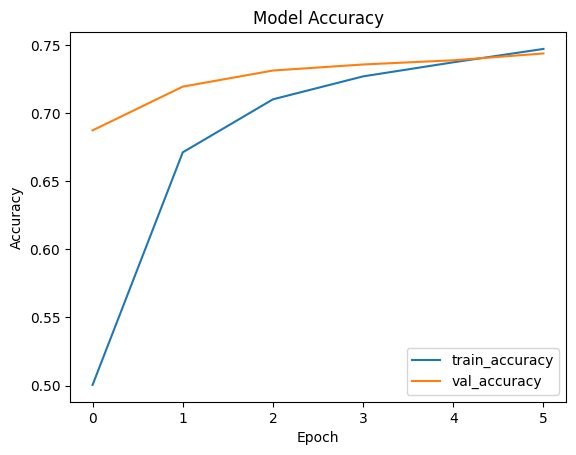

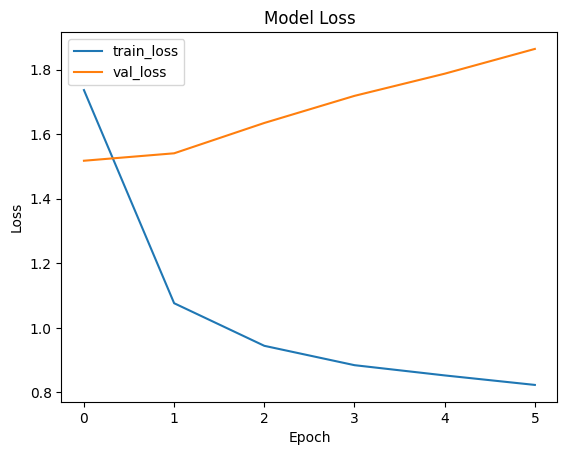

In [14]:
# === Visualing ===
# Accuracy
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [15]:
loss, accuracy = model.evaluate(val_generator)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

8786/8786 [==============================] - 99s 11ms/step - loss: 1.5176 - accuracy: 0.6872
Validation Loss: 1.5175509452819824
Validation Accuracy: 0.6872296929359436


In [16]:
def get_class_names_from_directory(DATA_DIR):
    class_names = sorted([
        d for d in os.listdir(DATA_DIR)
        if os.path.isdir(os.path.join(DATA_DIR, d))
    ])
    return class_names

In [17]:
def predict_image_auto(img_path, model_path, training_dir, target_size=(224, 224)):
    
    # Step 1: Load model
    model = load_model(model_path)

    # Step 2: Get class names from training directory
    class_names = get_class_names_from_directory(training_dir)

    # Step 3: Load and preprocess image
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # shape (1, 224, 224, 3)
    img_array = img_array / 255.0  # normalize like training

    # Step 4: Predict
    predictions = model.predict(img_array)
    predicted_index = np.argmax(predictions[0])
    predicted_class = class_names[predicted_index]
    confidence = predictions[0][predicted_index]

    print(f"✅ Predicted Class: {predicted_class} ({confidence:.2f} confidence)")
    return predicted_class

In [18]:
# ===Saving The Model===
model.save(MODEL_SAVE_PATH)
print(f"Model saved to {MODEL_SAVE_PATH}")


Model saved to ../Model\plant_model_v1.h5
